# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

import torch
from sklearn import datasets, decomposition

In [3]:

from polcanet import PolcaNet
from polcanet.example_aencoders import autoencoder_factory, generate_2d_sinusoidal_data
from polcanet.reports import analyze_latent_space, show_correlation_matrix, plot_scatter_corr_matrix, plot_stdev_pct, \
    plot_cumsum_variance, analyze_latent_feature_importance, analyze_reconstruction_error, orthogonality_test_analysis, \
    variance_test_analysis, linearity_tests_analysis


In [4]:
np.random.seed(5)

In [5]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load iris dataset

In [6]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

### Fit standard sklearn PCA

In [7]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
Xpca = pca.transform(X)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

### Fit POLCANet

In [8]:
ae_input = X
act_fn = torch.nn.Mish()

aencoder_iris = autoencoder_factory(
    input_dim=ae_input.shape[1],
    latent_dim=ae_input.shape[1],
    hidden_dim=256,
    num_layers=1,
    autoencoder_type="dense",
    act_fn=act_fn,
)

model_iris = PolcaNet(
    model=aencoder_iris,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.1,  # variance reduction loss
    device="cuda:0",
)
model_iris

PolcaNet(
  (model): BaseAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): Mish()
      (2): Linear(in_features=256, out_features=4, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=4, bias=True)
    )
  )
  (reconstruction_loss_fn): MSELoss()
)

In [9]:
model_iris.to("cuda:0")
model_iris.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.06451
decode: 0.001088
orth: 0.4992
com: 0.006371
var: 0.07129


In [10]:
model_iris.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.06311
decode: 0.001429
orth: 0.4877
com: 0.005746
var: 0.07165


## Evaluate results

In [54]:
latents, reconstructed = model_iris.predict(X)

In [55]:
analyze_latent_space(model_iris, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 4
Total variance in latent space: 2.3116

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.9151
First 5 components              1
Components for 95% variance     2
Variance Concentration Metric   0.9782

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0435
Median absolute off-diagonal          0.0223
Max absolute off-diagonal             0.1677
Proportion of |Orthogonality| > 0.1   0.1667
Orthogonality Success Metric          0.9565

Orthogonality Interpretation:
Excellent orthogonality of features.

4. De

/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/conda/envs/python3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


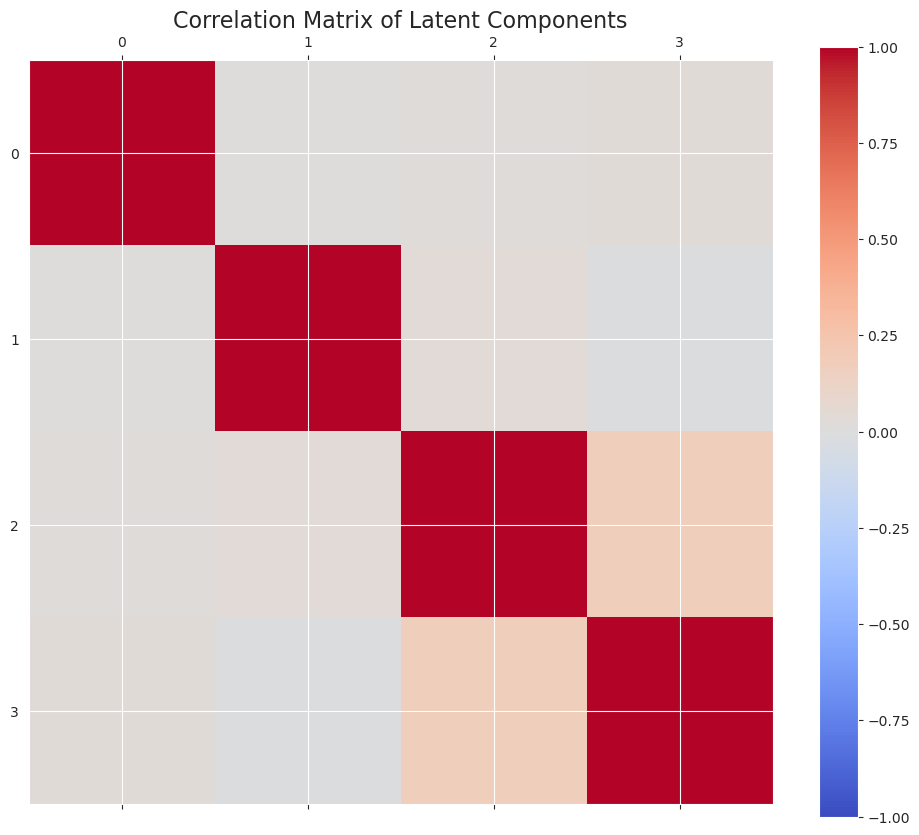

In [56]:
show_correlation_matrix(model_iris,latents)

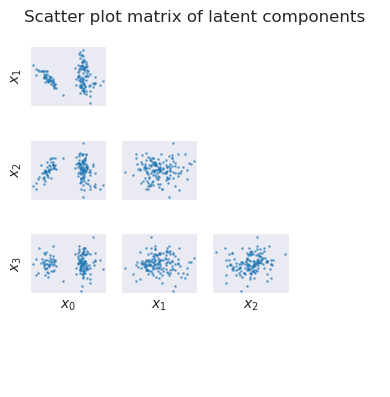

In [57]:
plot_scatter_corr_matrix(model_iris,latents)

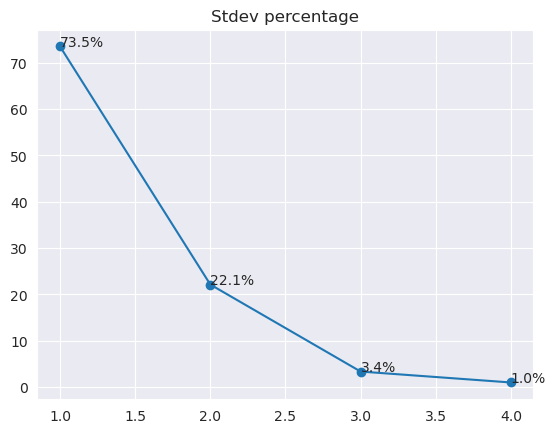

In [58]:
plot_stdev_pct(model_iris)

(1) reconstruction error: 0.2422, variance: 94.0%, with      1  active latent components
(2) reconstruction error: 0.1208, variance: 97.3%, with      2  active latent components
(3) reconstruction error: 0.0083, variance: 99.8%, with      3  active latent components
(4) reconstruction error: 0.0014, variance: 100.0%, with      4  active latent components


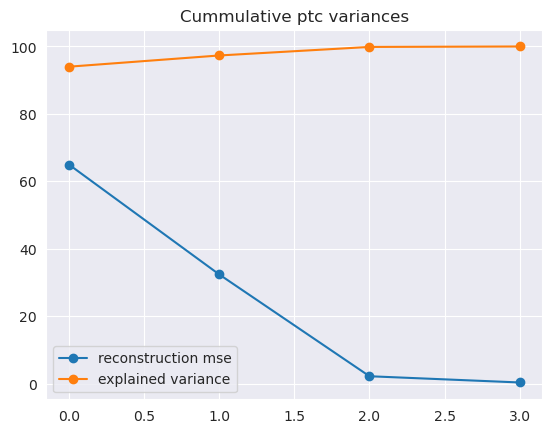

In [59]:
plot_cumsum_variance(model_iris,X)

### Polca Net vs. PCA

In [60]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
        ax.scatter(X[y == label, 0], X[y == label, 1], label=name)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [61]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _,_ = plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _,_ = plot2d_analysis(latents, y, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

In [62]:
o1 = widgets.Output()
o2 = widgets.Output()
o3 = widgets.Output()
o4 = widgets.Output()

with o1:
    fig1, ax1 = plot2d_analysis(X, y, "Original data two first componets", legend=False)

with o2:
    fig2, ax2 = plot2d_analysis(pca.inverse_transform(Xpca), y, "Reconstructed with PCA two componets", legend=False)

with o3:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 0, 0]))
    fig3, ax3 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA two componets", legend=False)

with o4:
    latents, reconstructed = model_iris.predict(X, np.array([1, 1, 1, 1]))
    fig4, ax4 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA all componets", legend=False)


layout = widgets.Layout(grid_template_columns="repeat(2, 450px)")
accordion = widgets.GridBox(children=[o1, o2, o3, o4], layout=layout)
display(accordion)

GridBox(children=(Output(), Output(), Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 450p…

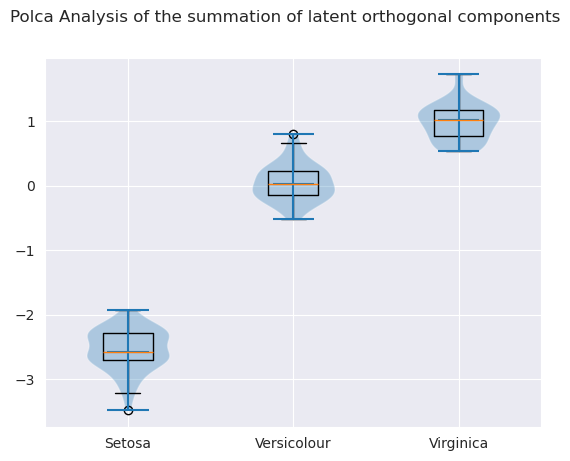

In [63]:
latents, reconstructed = model_iris.predict(X)
vectors = []
labels = ["Setosa", "Versicolour", "Virginica"]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [64]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model_iris.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last componet with clean data")
    plt.show()

with o2:
    scores = model_iris.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

In [24]:
model_iris.std_metrics

array([1.4544063 , 0.4376863 , 0.06618129, 0.01950974], dtype=float32)

In [25]:
model_iris.mean_metrics

array([-0.8230024 , -0.05900656, -0.0745754 ,  0.4558109 ], dtype=float32)

In [26]:
# Parameters
N = 32  # Sequence length
M = 32  # Number of features
num_samples = 1000

# Generate 2D sinusoidal data
data = generate_2d_sinusoidal_data(N, M, num_samples)
data.shape

(1000, 32, 32)

In [27]:
aencoder_lstm = autoencoder_factory(
    input_dim=M,
    latent_dim=256,
    hidden_dim=None,
    num_layers=3,
    autoencoder_type="lstm",
    seq_len=N,
    act_fn=act_fn,
)

model_lstm = PolcaNet(
    model=aencoder_lstm,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
)

In [28]:
model_lstm.to_device("cuda")
model_lstm.train_model(data=data, batch_size=512, num_epochs=20000, report_freq=10, lr=0.001)

epoch:   0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
aencoder_conv2d = autoencoder_factory(
    input_dim=M,
    latent_dim=64,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    seq_len=N,
)

model = PolcaNet(
    model=aencoder_conv2d,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=0.1,  # variance reduction loss
    device="cuda",
)
model

PolcaNet(
  (model): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Flatten(start_dim=1, end_dim=-1)
    )
    (decoder): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(64, 2, 2))
      (1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (4): ConvTranspos

In [30]:
model.to_device("cuda:1")
model.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.004801
decode: 0.0001196
orth: 0.03513
com: 0.0006119
var: 0.0001286


In [31]:
model.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
loss: 0.003657
decode: 0.0001573
orth: 0.02791
com: 0.0002843
var: 6.781e-05


In [34]:
latents, reconstructed = model.predict(data)
data.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 256))

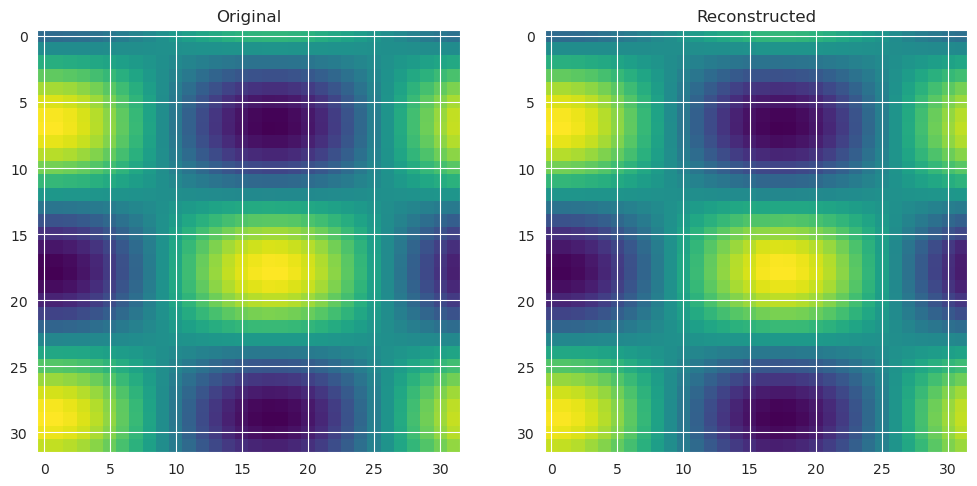

In [35]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

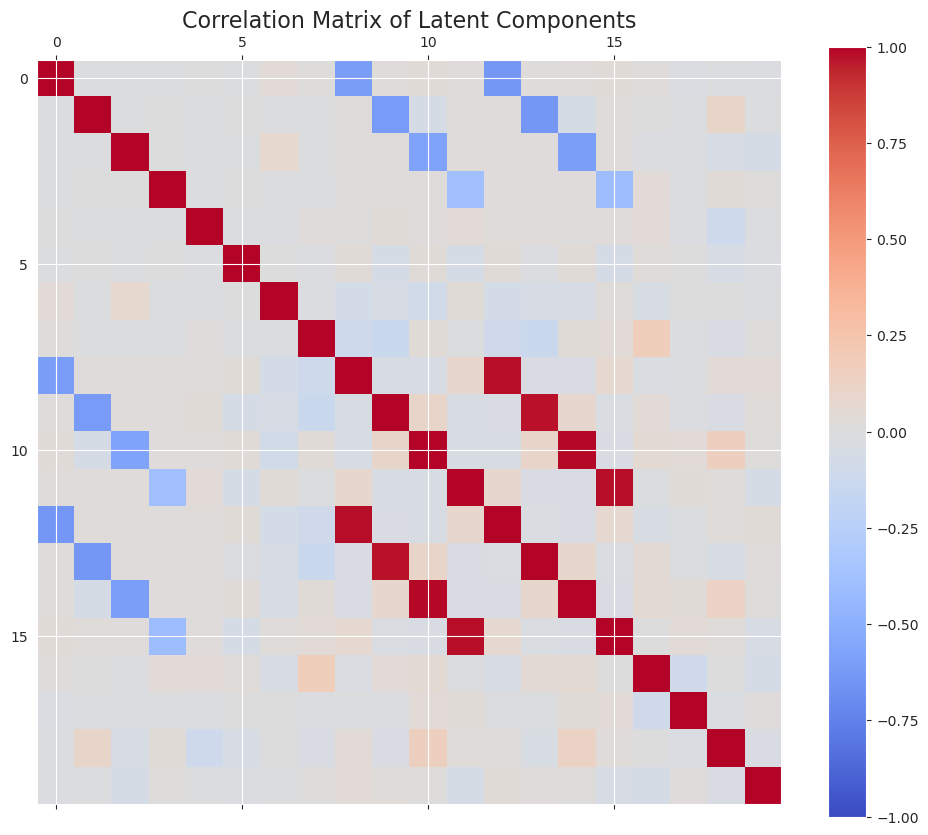

In [36]:
show_correlation_matrix(model,latents=latents[:, :20])

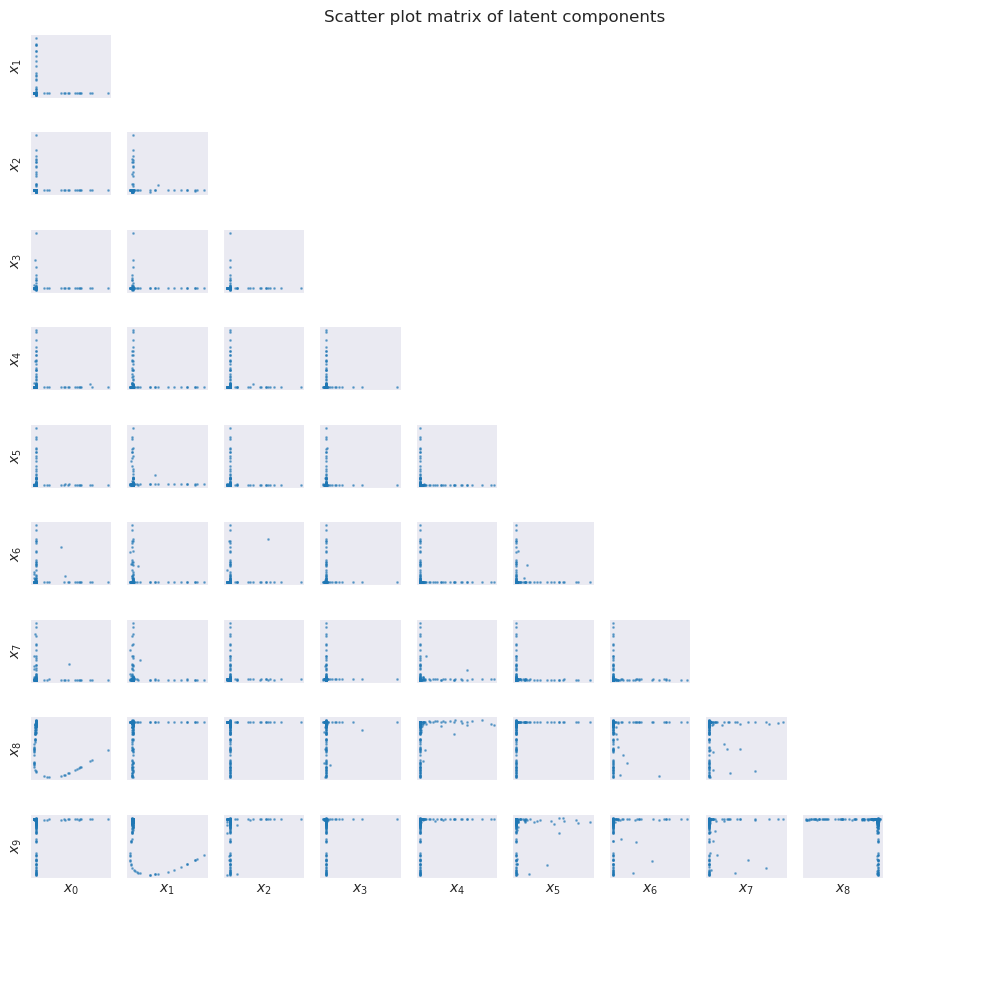

In [37]:
plot_scatter_corr_matrix(model, latents, n_components=10)

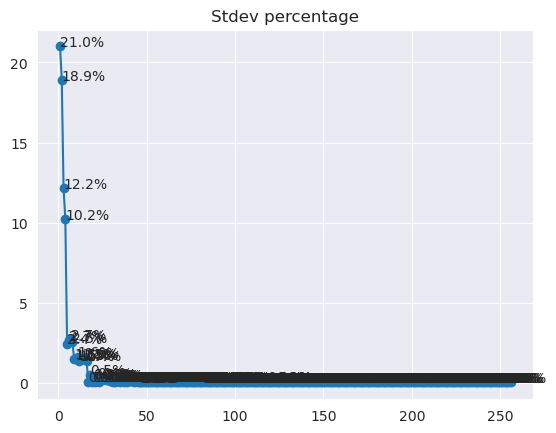

In [38]:
plot_stdev_pct(model)

(1) reconstruction error: 0.2501, variance: 1.7%, with      1  active latent components
(2) reconstruction error: 0.2501, variance: 1.7%, with      2  active latent components
(3) reconstruction error: 0.2501, variance: 1.7%, with      3  active latent components
(4) reconstruction error: 0.2501, variance: 1.7%, with      4  active latent components
(5) reconstruction error: 0.2500, variance: 1.7%, with      5  active latent components
(6) reconstruction error: 0.2500, variance: 1.7%, with      6  active latent components
(7) reconstruction error: 0.2499, variance: 1.7%, with      7  active latent components
(8) reconstruction error: 0.2498, variance: 1.7%, with      8  active latent components
(9) reconstruction error: 0.2493, variance: 1.9%, with      9  active latent components
(10) reconstruction error: 0.2490, variance: 2.1%, with     10  active latent components
(11) reconstruction error: 0.2488, variance: 2.3%, with     11  active latent components
(12) reconstruction error: 0.2

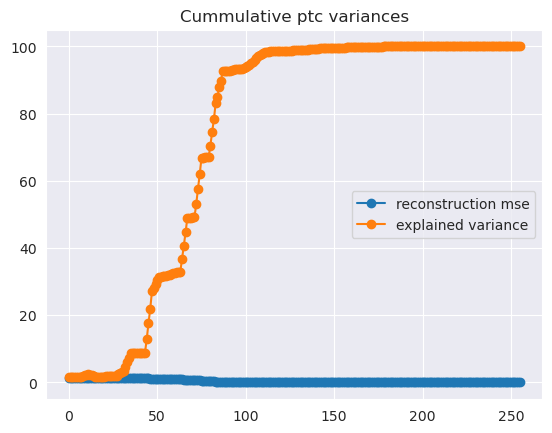

In [39]:
plot_cumsum_variance(model, data)

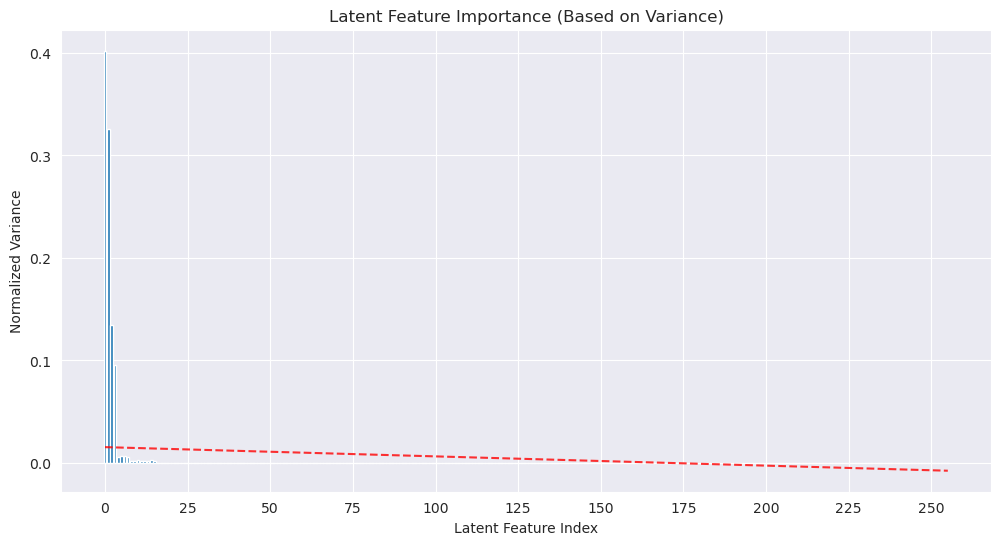

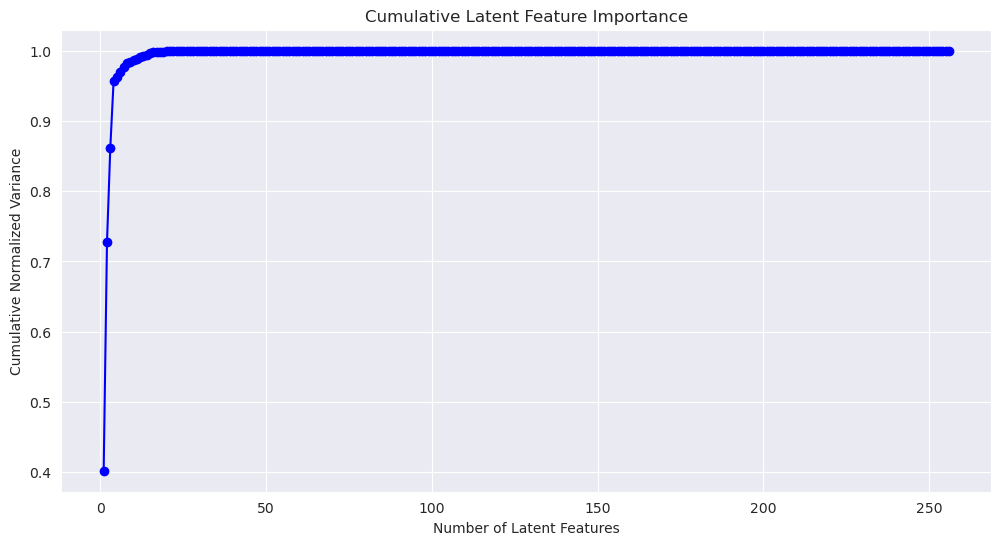

First feature importance: 0.4022
Last feature importance: 0.0000
Ratio of first to last feature importance: 267985.7500
Number of features explaining 80% of the variance: 3
Intrinsic Dimension: 6.78


In [40]:
analyze_latent_feature_importance(model, data)

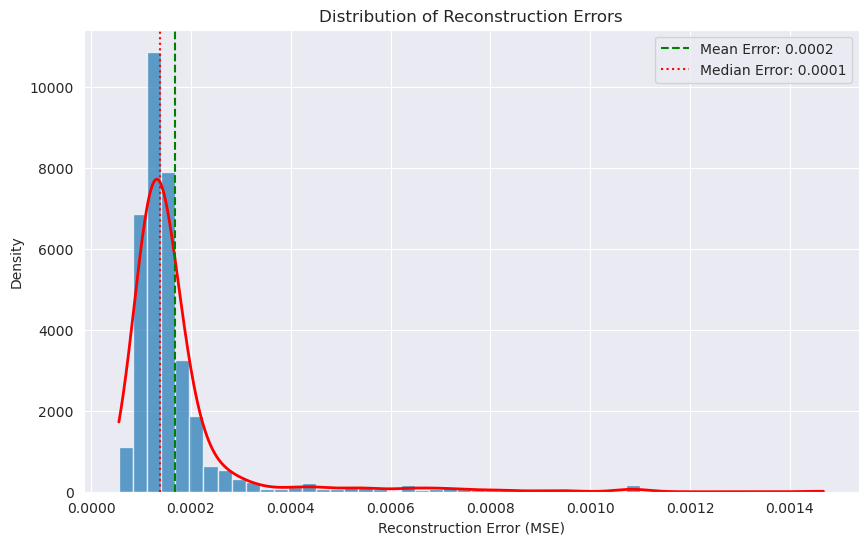

Mean Reconstruction Error: 0.0002
Median Reconstruction Error: 0.0001
Min Reconstruction Error: 0.0001
Max Reconstruction Error: 0.0015


In [41]:
analyze_reconstruction_error(model, data, n_samples=10000)

In [42]:
analyze_latent_space(model, data=data)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 256
Total variance in latent space: 0.3034

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4022
First 5 components              0.963
Components for 95% variance     4
Variance Concentration Metric   0.9949

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0463
Median absolute off-diagonal          0.0353
Max absolute off-diagonal             0.9856
Proportion of |Orthogonality| > 0.1   0.0898
Orthogonality Success Metric          0.9537

Orthogonality Interpretation:
Excellent orthogonality of features.



    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 100 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0008
    - Max cosine similarity: 0.9824
    - Min cosine similarity: -0.7947
    


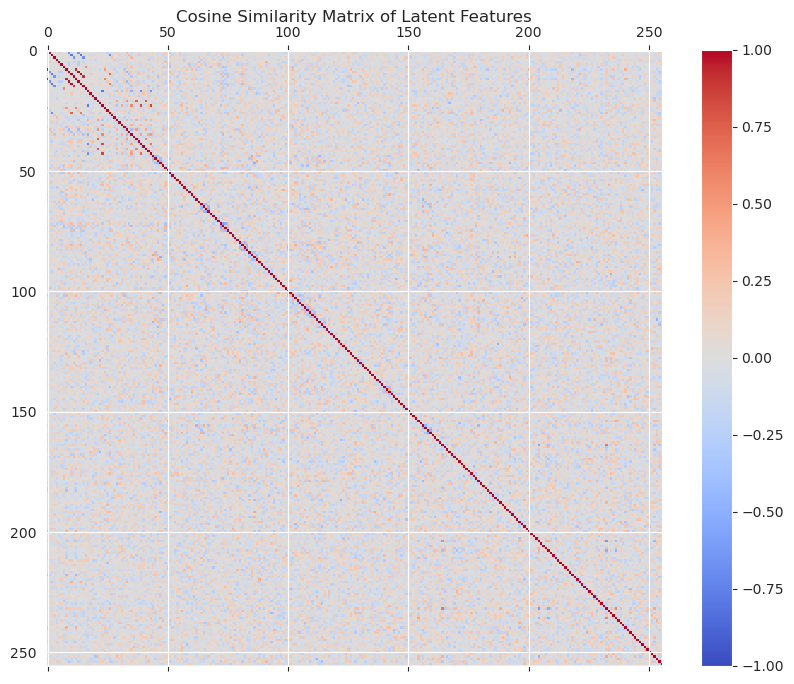

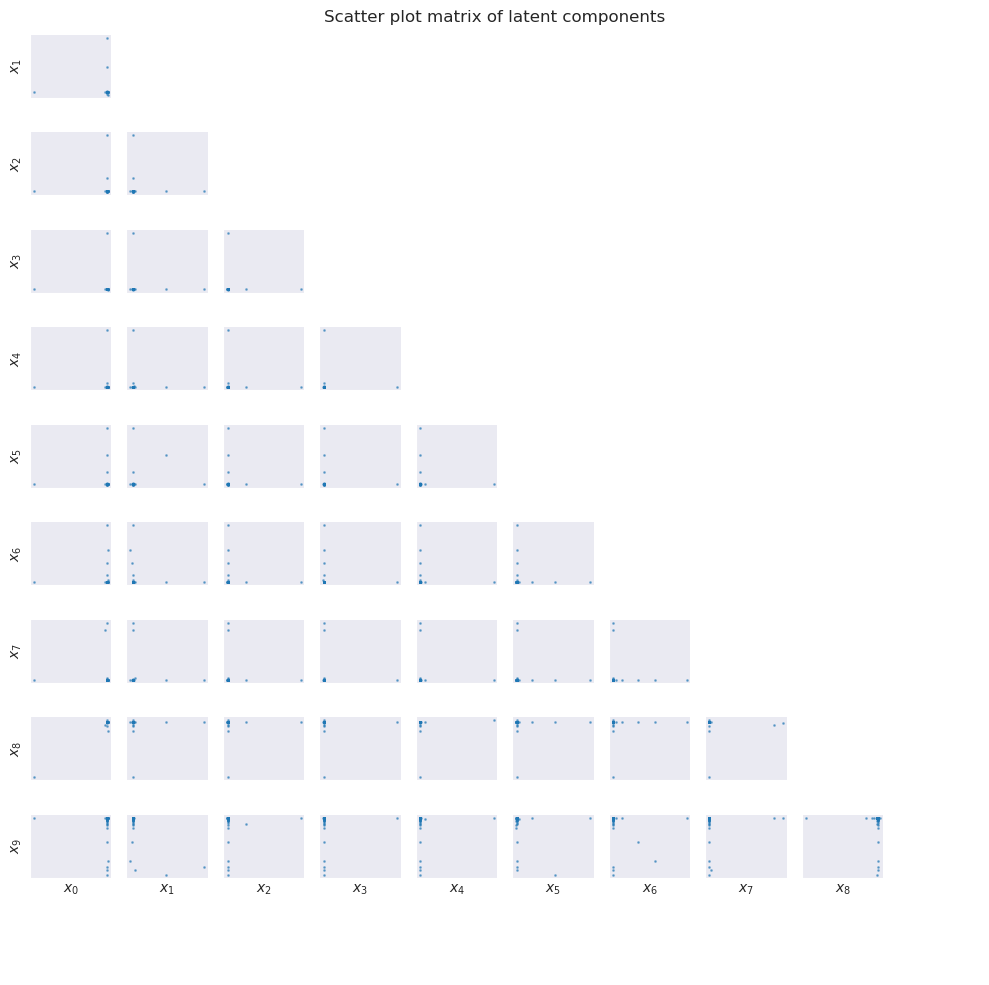

In [44]:
orthogonality_test_analysis(model, data)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 100 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.4831
    - Variance fit to exponential distribution (sum of squared differences): 0.9162
    


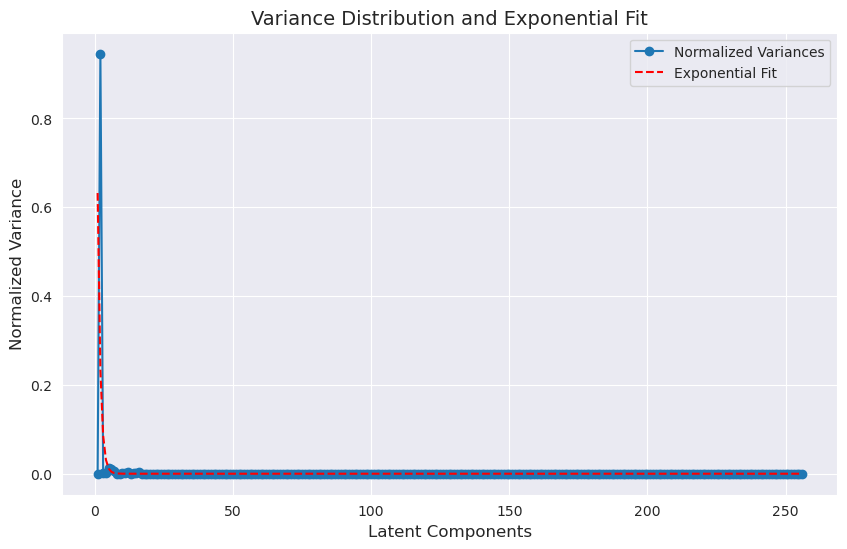

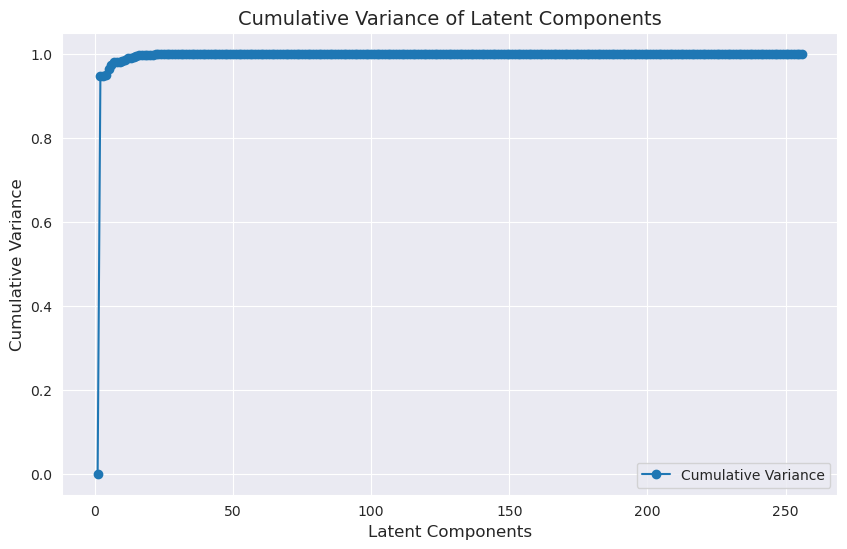

Top 20 Components Variance Analysis:
Component 1: Normalized Variance = 0.0002, Cumulative Variance = 0.0002
Component 2: Normalized Variance = 0.9459, Cumulative Variance = 0.9460
Component 3: Normalized Variance = 0.0020, Cumulative Variance = 0.9480
Component 4: Normalized Variance = 0.0015, Cumulative Variance = 0.9496
Component 5: Normalized Variance = 0.0137, Cumulative Variance = 0.9632
Component 6: Normalized Variance = 0.0099, Cumulative Variance = 0.9731
Component 7: Normalized Variance = 0.0070, Cumulative Variance = 0.9802
Component 8: Normalized Variance = 0.0000, Cumulative Variance = 0.9802
Component 9: Normalized Variance = 0.0002, Cumulative Variance = 0.9804
Component 10: Normalized Variance = 0.0025, Cumulative Variance = 0.9829
Component 11: Normalized Variance = 0.0022, Cumulative Variance = 0.9851
Component 12: Normalized Variance = 0.0038, Cumulative Variance = 0.9889
Component 13: Normalized Variance = 0.0002, Cumulative Variance = 0.9891
Component 14: Normalize

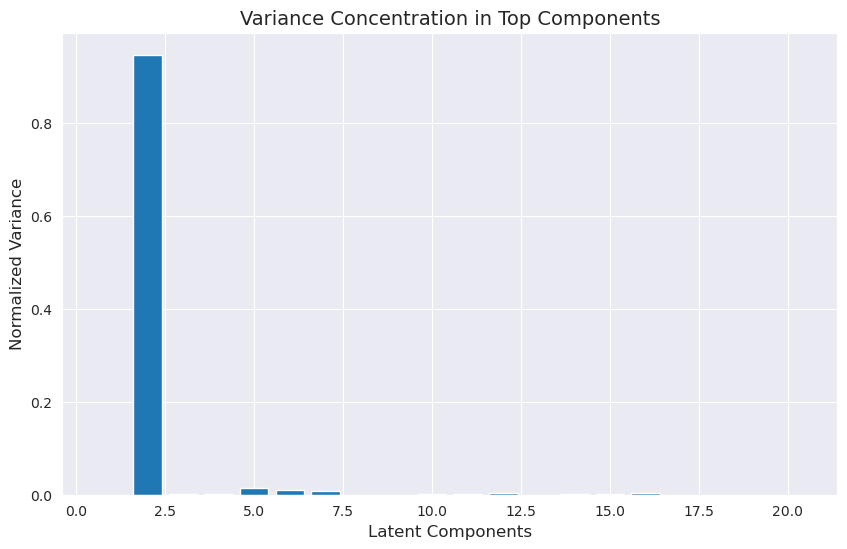

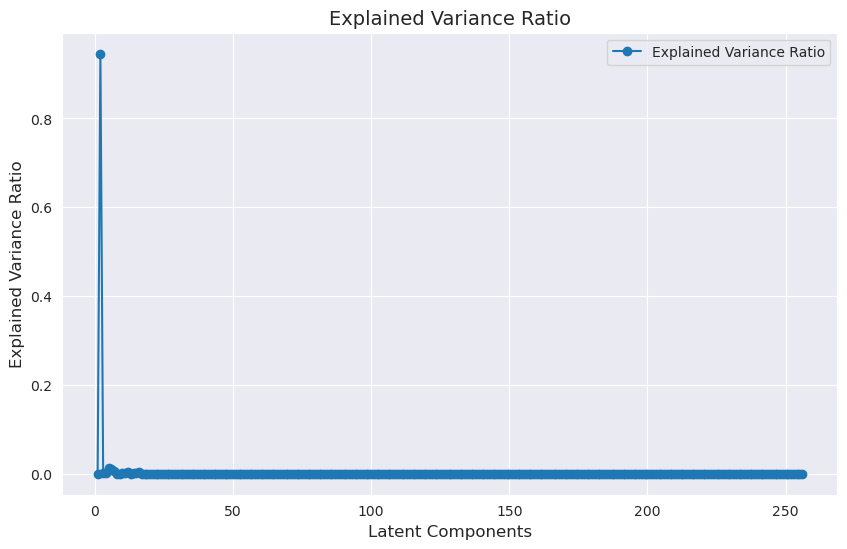

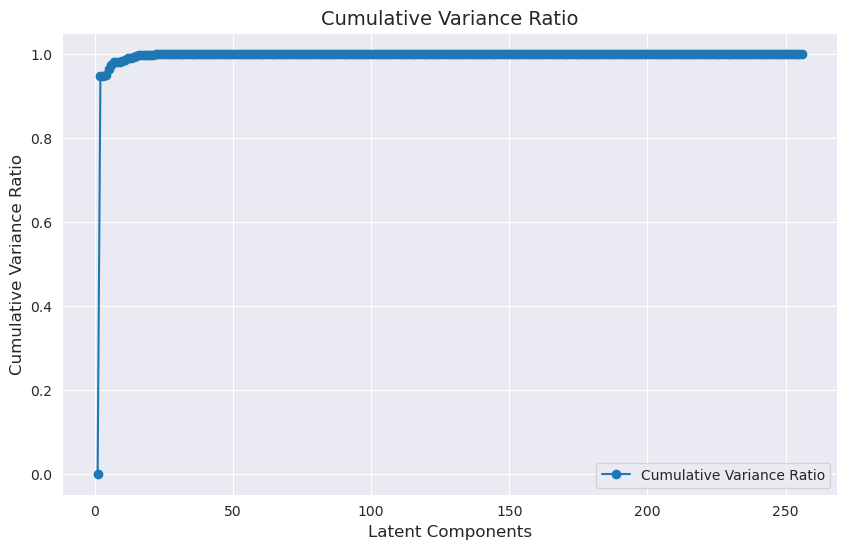

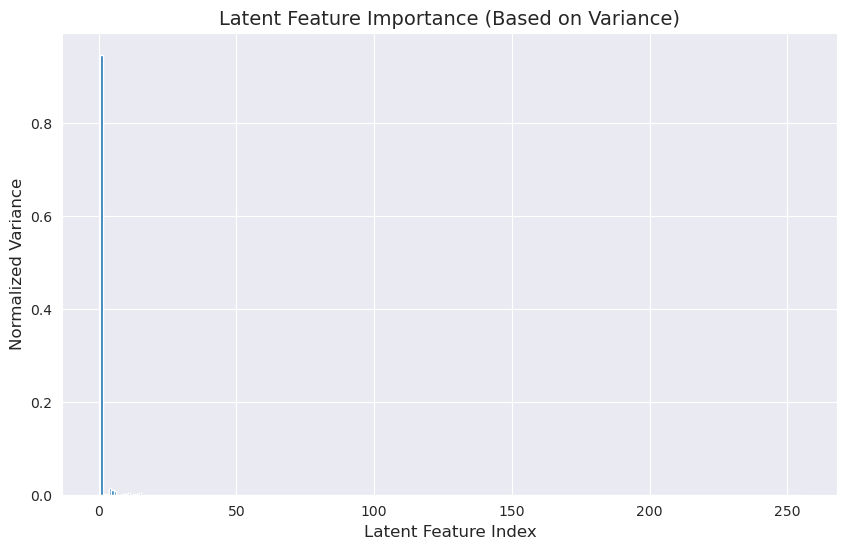

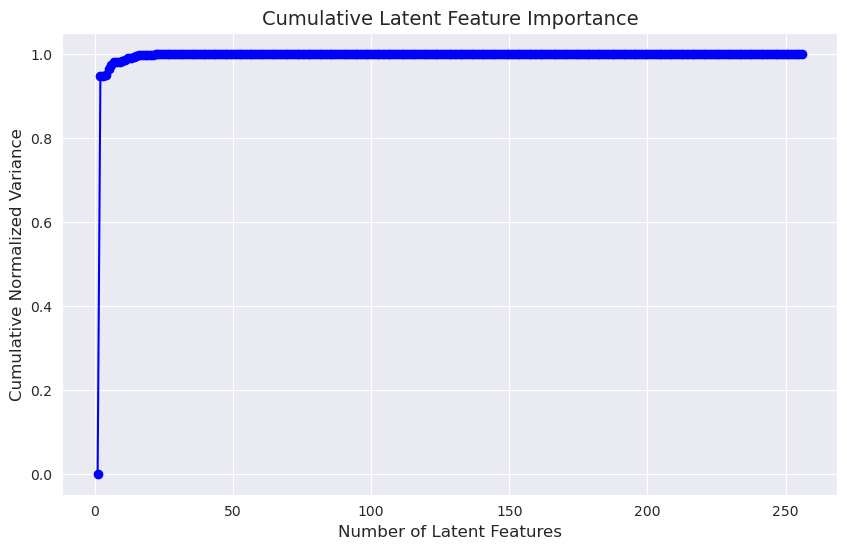

In [45]:
variance_test_analysis(model, data)


    Linearity Tests Analysis

    This report analyzes the linearity properties of the autoencoder. We used a sample size of 
    100 randomly selected data points for the analysis.

    The linearity properties of the features are assessed through two tests: additive property 
    and homogeneity property. The results are summarized below:

    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:

    f(z(x) + z(y)) = f(z(x)) + f(z(y))

    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:

    - Mean difference: 0.0025
    - Max difference: 0.0069
    - Min difference: 0.0000

    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:

    f(a.z(x)) = a.f(z(x))

    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:

    - Mean difference: 0

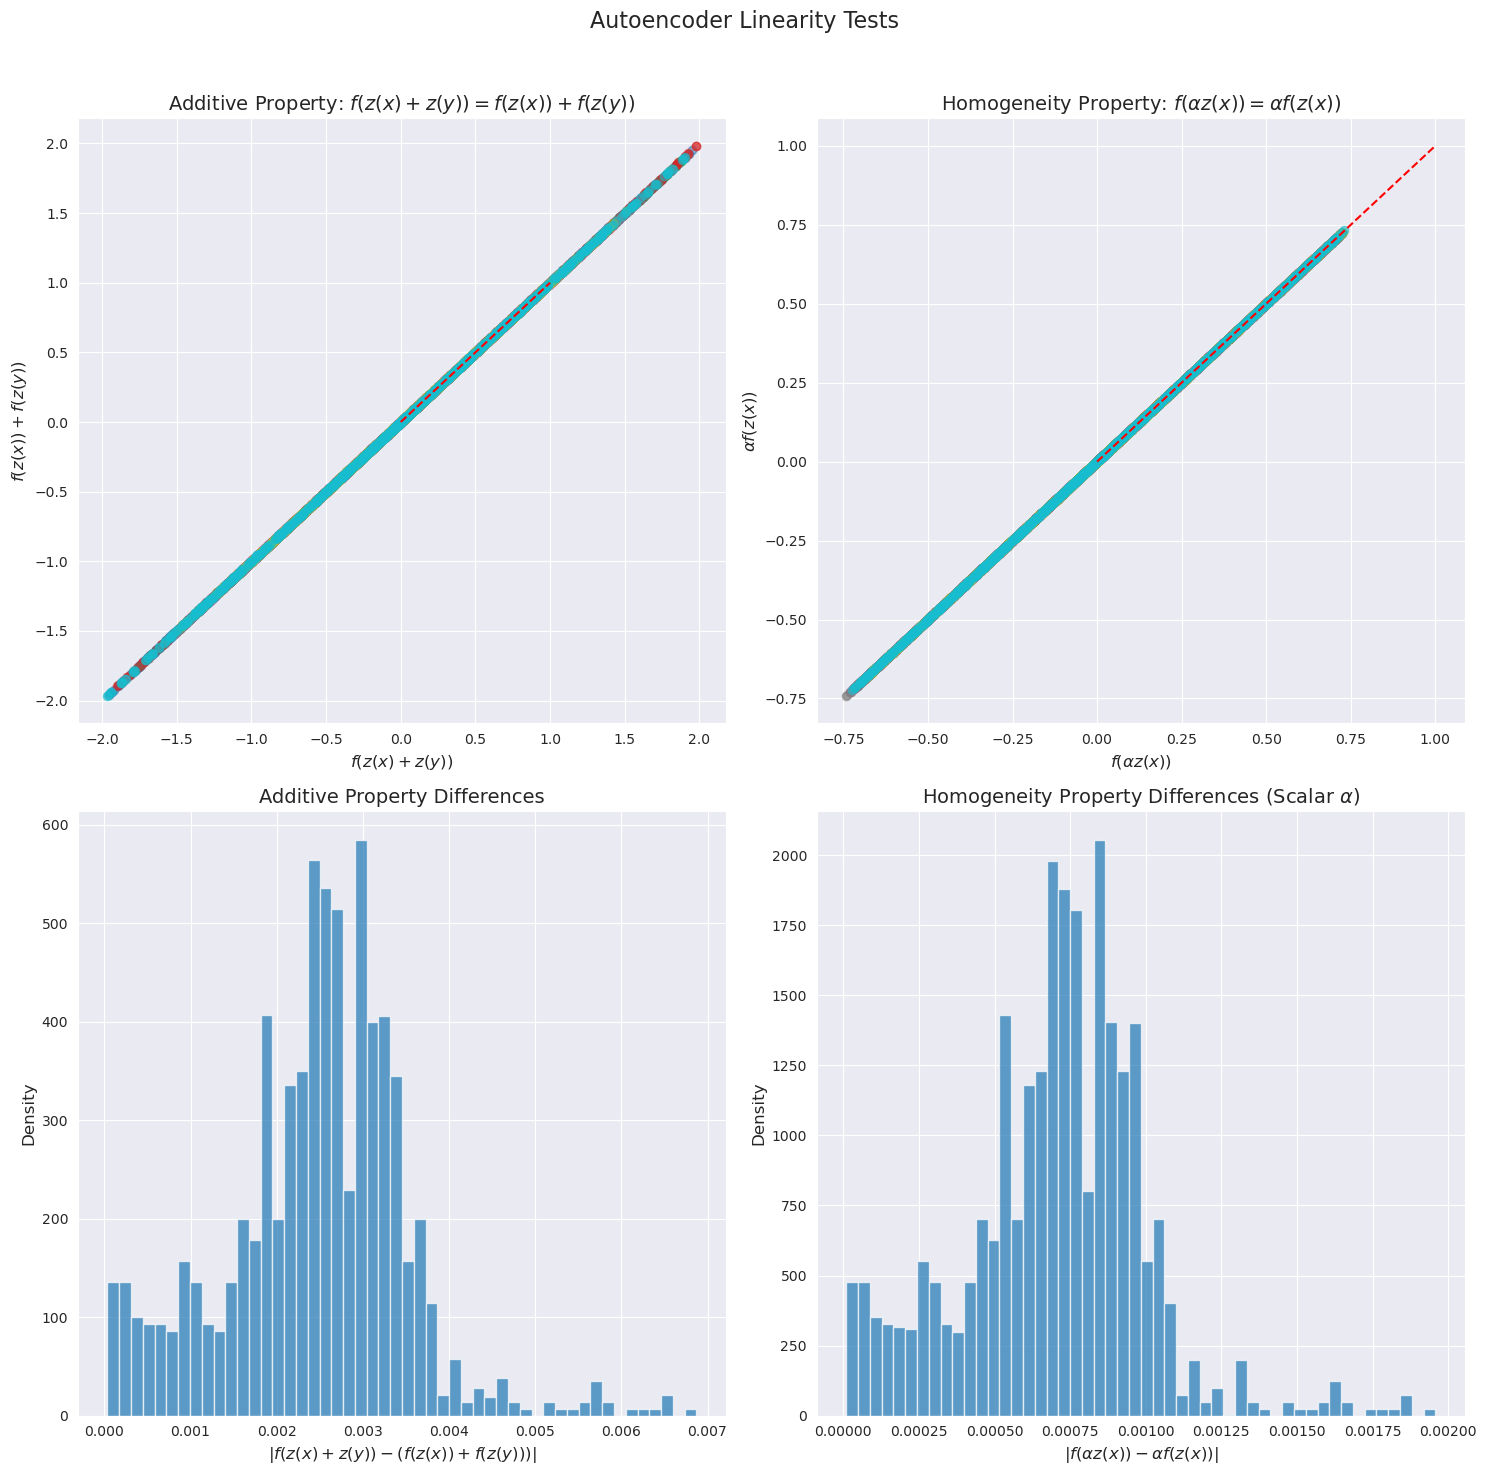

In [46]:
linearity_tests_analysis(model, data)